In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse, TestSynapse
from jaxley_mech.channels.fm97 import Na, K, KA, KCa, Ca, Leak

import warnings
import networkx as nx
from jaxley.connection import connect
import pandas as pd

from jaxley.io.graph import to_graph, from_graph
from jaxley.io.swc import swc_to_jaxley#, swc_to_graph
from jaxley.io.graph import from_graph
from jaxley.io.swc import swc_to_graph

In [4]:
comp = jx.Compartment()
branch = jx.Branch([comp for _ in range(4)])
cell1 = jx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 1, 2, 2]))
cell2 = jx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 1, 2, 2]))

cell1 == cell2

True

In [5]:
def recursive_compare(a,b):
    if type(a) != type(b):
        return False
    if isinstance(a, (int, float)):
        if a != b and not(np.isnan(a) and np.isnan(b)):
            return False
    elif isinstance(a, str):
        if a != b:
            return False
    elif isinstance(a, (np.ndarray, jnp.ndarray)):
        if a.size > 1:
            for i in range(len(a)):
                if not recursive_compare(a[i], b[i]):
                    return False
        else:
            if not recursive_compare(a.item(), b.item()):
                return False
    elif isinstance(a, (list, tuple)):
        if len(a) != len(b):
            return False
        for i in range(len(a)):
            if not recursive_compare(a[i], b[i]):
                return False
    elif isinstance(a, dict):
        if len(a) != len(b) and len(a) != 0:
            return False
        if set(a.keys()) != set(b.keys()):
            return False
        for k in a.keys():
            if not recursive_compare(a[k], b[k]):
                return False
    elif isinstance(a, pd.DataFrame):
        if not recursive_compare(a.to_dict(), b.to_dict()):
            return False
    elif a is None or b is None:
        if not (a is None and b is None):
            return False
    else:
        raise ValueError(f"Type {type(a)} not supported")
    return True

recursive_compare(cell1.__dict__, cell2.__dict__)

True

In [5]:
from jaxley.io.graph import get_linear_paths, path_e2n, path_n2e, build_module_scaffold, make_jaxley_compatible

In [725]:
import jax

from jaxley.io.graph import from_graph, make_jaxley_compatible
from jaxley.io.swc import swc_to_graph, swc_to_jaxley

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import numpy as np
from neuron import h

import jaxley as jx
from jaxley.channels import HH

_ = h.load_file("stdlib.hoc")
_ = h.load_file("import3d.hoc")

def test_swc_voltages(use_graph=False):
    """Check if voltages of SWC recording match.

    To match the branch indices between NEURON and jaxley, we rely on comparing the
    length of the branches.

    It tests whether, on average over time and recordings, the voltage is off by less
    than 1.5 mV.
    """
    fname = os.path.join("../tests/", "morph.swc")  # n120

    i_delay = 2.0
    i_dur = 5.0
    i_amp = 0.25
    t_max = 20.0
    dt = 0.025

    nseg_per_branch = 8

    ##################### NEURON ##################
    for sec in h.allsec():
        h.delete_section(sec=sec)

    cell = h.Import3d_SWC_read()
    cell.input(fname)
    i3d = h.Import3d_GUI(cell, False)
    i3d.instantiate(None)

    for sec in h.allsec():
        sec.nseg = nseg_per_branch

    pathlengths_neuron = np.asarray([sec.L for sec in h.allsec()])

    ####################### jaxley ##################
    if use_graph:
        graph = swc_to_graph(fname)
        graph = make_jaxley_compatible(graph, max_branch_len=2000.0, nseg=8)
        cell = from_graph(graph, nseg=8, max_branch_len=2000.0)
    else:
        _, pathlengths, _, _, _ = swc_to_jaxley(fname, max_branch_len=2000)
        cell = jx.read_swc(fname, 8, max_branch_len=2000.0, assign_groups=True)
        cell._update_nodes_with_xyz()

    cell.insert(HH())

    neuron_coords = {i: np.vstack(get_segment_coordinates(sec, 0.05)).T for i, sec in enumerate(h.allsec())}
    # neuron_coords = {i: np.vstack(get_segment_coordinates(sec)).T for i, sec in enumerate(h.allsec())}
    neuron_coords = np.vstack([np.hstack([k*np.ones((v.shape[0], 1)), v]) for k,v in neuron_coords.items()])
    neuron_coords = pd.DataFrame(neuron_coords, columns=["branch_index", "x", "y", "z"])
    neuron_coords["branch_index"] = neuron_coords["branch_index"].astype(int)

    neuron_loc_xyz = neuron_coords.groupby("branch_index").mean()
    # jaxley_loc_xyz = cell.nodes.groupby("branch_index").mean()[["x", "y", "z"]]
    jaxley_loc_xyz = cell.branch("all").loc(0.05).show().set_index("branch_index")[["x", "y", "z"]]

    jaxley2neuron_inds = {}
    for i, xyz in jaxley_loc_xyz.iterrows():
        d = np.sqrt((neuron_loc_xyz - xyz).pow(2).sum(axis=1))
        jaxley2neuron_inds[i] = d.argmin()

    y_apical = cell.apical.show().groupby("branch_index").mean()["y"].abs().sort_values()
    trunk_inds = y_apical.index[:20:3].tolist()
    tuft_inds = y_apical.index[-20::3].tolist()
    basal_inds = cell.basal.show()["branch_index"].unique()[::8].tolist()

    neuron_trunk_inds = [jaxley2neuron_inds[i] for i in trunk_inds]
    neuron_tuft_inds = [jaxley2neuron_inds[i] for i in tuft_inds]
    neuron_basal_inds = [jaxley2neuron_inds[i] for i in basal_inds]
    print(trunk_inds, neuron_trunk_inds)
    print(tuft_inds, neuron_tuft_inds)
    print(basal_inds, neuron_basal_inds)

    cell.set("axial_resistivity", 1_000.0)
    cell.set("v", -62.0)
    cell.set("HH_m", 0.074901)
    cell.set("HH_h", 0.4889)
    cell.set("HH_n", 0.3644787)

    cell.branch(1).loc(0.05).stimulate(
        jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
    )
    for i in trunk_inds + tuft_inds + basal_inds:
        cell.branch(i).loc(0.05).record()

    voltages_jaxley = jx.integrate(cell, delta_t=dt)

    ################### NEURON #################
    stim = h.IClamp(h.soma[0](0.1))
    stim.delay = i_delay
    stim.dur = i_dur
    stim.amp = i_amp

    counter = 0
    voltage_recs = {}

    for r in neuron_trunk_inds:
        for i, sec in enumerate(h.allsec()):
            if i == r:
                v = h.Vector()
                v.record(sec(0.05)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1

    for r in neuron_tuft_inds:
        for i, sec in enumerate(h.allsec()):
            if i == r:
                v = h.Vector()
                v.record(sec(0.05)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1

    for r in neuron_basal_inds:
        for i, sec in enumerate(h.allsec()):
            if i == r:
                v = h.Vector()
                v.record(sec(0.05)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1

    for sec in h.allsec():
        sec.insert("hh")
        sec.Ra = 1_000.0

        sec.gnabar_hh = 0.120  # S/cm2
        sec.gkbar_hh = 0.036  # S/cm2
        sec.gl_hh = 0.0003  # S/cm2
        sec.ena = 50  # mV
        sec.ek = -77.0  # mV
        sec.el_hh = -54.3  # mV

    h.dt = dt
    tstop = t_max
    v_init = -62.0

    def initialize():
        h.finitialize(v_init)
        h.fcurrent()

    def integrate():
        while h.t < tstop:
            h.fadvance()

    initialize()
    integrate()
    voltages_neuron = np.asarray([voltage_recs[key] for key in voltage_recs])

    ####################### check ################
    error = np.mean(np.abs(voltages_jaxley - voltages_neuron) < 1.5)

    assert error, "voltages do not match."
    return voltages_jaxley, voltages_neuron

In [721]:
def get_segment_coordinates(section, loc=None):
    n3d = section.n3d()
    x3d = np.array([section.x3d(i) for i in range(n3d)])
    y3d = np.array([section.y3d(i) for i in range(n3d)])
    z3d = np.array([section.z3d(i) for i in range(n3d)])
    L = np.array([section.arc3d(i) for i in range(n3d)])  # Cumulative arc lengths
    if loc is None:
        return x3d, y3d, z3d
    else:
        total_length = L[-1]
        target_length = loc * total_length

        # Find segment containing target_length
        for i in range(1, n3d):
            if L[i] >= target_length:
                break
        else:
            i = n3d - 1

        # Interpolate between points i-1 and i
        L0, L1 = L[i-1], L[i]
        t = (target_length - L0) / (L1 - L0)
        x = x3d[i-1] + t * (x3d[i] - x3d[i-1])
        y = y3d[i-1] + t * (y3d[i] - y3d[i-1])
        z = z3d[i-1] + t * (z3d[i] - z3d[i-1])
        return x, y, z

In [816]:
fname = os.path.join("../tests/", "morph.swc")  # n120
graph = swc_to_graph(fname)
graph = make_jaxley_compatible(graph, max_branch_len=2000.0, nseg=8)

In [ ]:
nodes = pd.DataFrame((n for i, n in graph.nodes(data=True)))
nodes = nodes.sort_values("comp_index", ignore_index=True) # ensure index == comp_index
edge_type = nx.get_edge_attributes(graph, "type")
edges = pd.DataFrame(edge_type.values(), index=edge_type.keys(), columns=["type"])
edges = edges.reset_index(names=["pre", "post"])
is_synapse = edges["type"] == "synapse"
is_inter_branch = edges["type"] == "inter_branch"
inter_branch_edges = edges.loc[is_inter_branch][["pre", "post"]].values
synapse_edges = edges.loc[is_synapse][["pre", "post"]].values
branch_edges = pd.DataFrame(nodes["branch_index"].values[inter_branch_edges], columns=["parent_branch_index", "child_branch_index"])
# branch_graph = nx.Graph((r.values for i,r in branch_edges.iterrows()))
# branch_edges = pd.DataFrame([(k,v) for k,v in nx.dfs_successors(branch_graph, source=0).items()], columns=["parent_branch_index", "child_branch_index"]).explode("child_branch_index")

edge_params = nx.get_edge_attributes(graph, "parameters")
edge_params = {k: v for k, v in edge_params.items() if k in synapse_edges}
synapse_edges = pd.DataFrame(sum(edge_params.values(), [])).T

acc_parents = []
parent_branch_inds = branch_edges.set_index("child_branch_index").sort_index()["parent_branch_index"]
for branch_inds in nodes.groupby("cell_index")["branch_index"].unique():
    root_branch_idx = branch_inds[0]
    parents = parent_branch_inds.loc[branch_inds[1:]] - root_branch_idx
    acc_parents.append([-1] + parents.tolist())

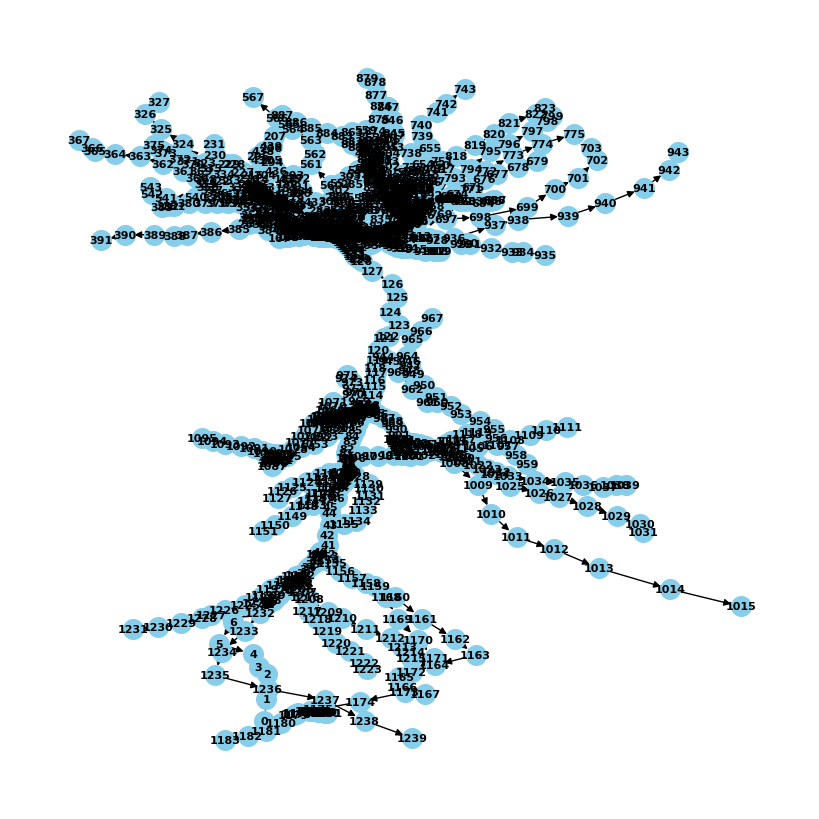

In [801]:
pos = {i: (n["x"], n["y"]) for i, n in graph.nodes(data=True)}
plt.figure(figsize=(8, 8))
nx.draw(graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", font_family="sans-serif")
# plt.xlim(-100, 100)
# plt.ylim(-200, 200)
plt.show()

In [815]:
fname = os.path.join("../tests/", "morph.swc")  # n120
graph = swc_to_graph(fname)
cell1 = from_graph(graph, nseg=8, max_branch_len=2000.0)

cell2 = jx.read_swc(fname, 8, max_branch_len=2000.0, assign_groups=True)
cell2._update_nodes_with_xyz()

In [803]:
cell1.nodes

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v,x,y,z
0,0,0,0,30.528381,0.24,5000.0,1.0,-70.0,-36.044611,-531.811576,51.322888
1,1,0,0,30.528381,0.24,5000.0,1.0,-70.0,-35.223228,-507.078324,41.910000
2,2,0,0,30.528381,0.24,5000.0,1.0,-70.0,-35.123482,-479.384480,36.106450
3,3,0,0,30.528381,0.24,5000.0,1.0,-70.0,-38.495109,-471.082619,60.629919
4,4,0,0,30.528381,0.24,5000.0,1.0,-70.0,-40.834146,-456.774716,55.391971
...,...,...,...,...,...,...,...,...,...,...,...
1235,1235,154,0,30.122771,0.24,5000.0,1.0,-70.0,-57.143061,-480.267188,24.790000
1236,1236,154,0,30.122771,0.24,5000.0,1.0,-70.0,-34.643942,-496.021811,27.204199
1237,1237,154,0,30.122771,0.24,5000.0,1.0,-70.0,-10.382692,-507.995828,31.120000
1238,1238,154,0,30.122771,0.24,5000.0,1.0,-70.0,6.417774,-531.310845,33.360000


In [7]:
# trunk_inds = [1, 4, 5, 13, 15, 21, 23, 24, 29, 33]
# tuft_inds = [6, 16, 18, 36, 38, 44, 51, 52, 53, 54]
# basal_inds = np.arange(81, 156, 8).tolist()

In [804]:
v1, vn1 = test_swc_voltages(use_graph=True)
# v2, vn2 = test_swc_voltages(use_graph=False)

[15, 14, 12, 133, 122, 134, 139] [104, 144, 107, 140, 151, 141, 136]
[128, 126, 3, 2, 151, 0, 148] [149, 147, 116, 117, 122, 129, 129]
[18, 26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114] [2, 10, 18, 26, 34, 42, 50, 58, 68, 76, 84, 92, 99]
Added 1 stimuli. See `.currents` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details

In [805]:
np.mean(np.abs(v1 - vn1), axis=1), np.mean(np.abs(v2 - vn2), axis=1)

(array([16.19631774,  1.29674435,  0.32062956,  2.877556  ,  1.87981784,
         2.79007424, 14.18799953,  0.87100228,  0.79204192, 22.16506021,
        24.50452318, 22.153952  , 21.54605546, 20.37592646, 20.89964001,
        20.03912879, 20.11289788, 20.3501605 , 20.55278685, 19.75237183,
        19.09583025, 19.08878063, 18.93032012, 19.12278327, 19.15781994,
        19.03490525, 20.2008044 ]),
 array([0.72412308, 0.7978693 , 0.81918308, 0.84724678, 0.80464105,
        1.43258348, 1.47786316, 0.73113843, 1.14953477, 1.12154859,
        1.18076938, 1.30564702, 1.56853646, 2.9105652 , 0.38078612,
        1.00738273, 0.79437486, 0.81636714, 0.48941009, 0.47586723,
        0.75917783, 1.04822786, 3.22180442, 1.56591299, 1.14104993,
        1.34106949, 1.72583906]))

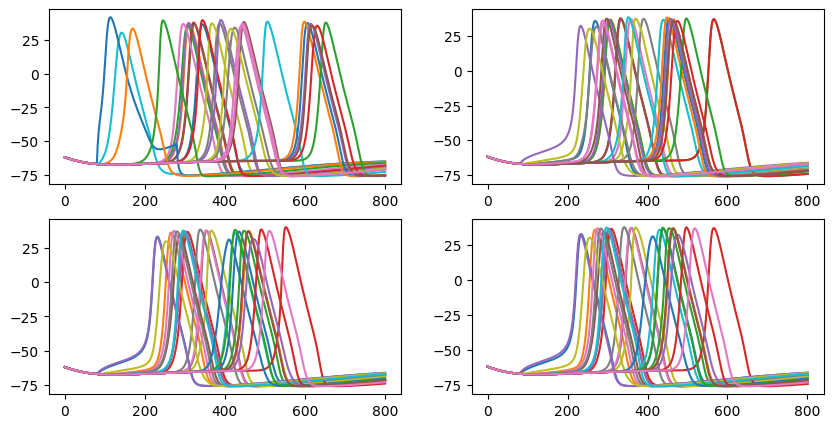

In [806]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0,0].plot(v1.T)
ax[0,1].plot(vn1.T)
ax[1,0].plot(v2.T)
ax[1,1].plot(vn2.T)
plt.show()

Points of note:
- How should we structure the tests and the io submodule?
- should we keep the legacy reader once tests pass?
- Documentation of the reader.

In [ ]:
# xyz_coords = np.array([list(nx.get_node_attributes(new_graph, x).values()) for x in "xyz"])
# center = np.mean(xyz_coords, axis=1)
# # find node closest to center
# center_node = np.argmin(np.sum((xyz_coords - center[:, None])**2, axis=0))

In [ ]:
fname = "../tests/morph.swc"
graph = swc_to_graph(fname)
# graph = impose_branch_structure(graph)
# graph = compartmentalize_branches(graph)
cell = from_graph(graph)

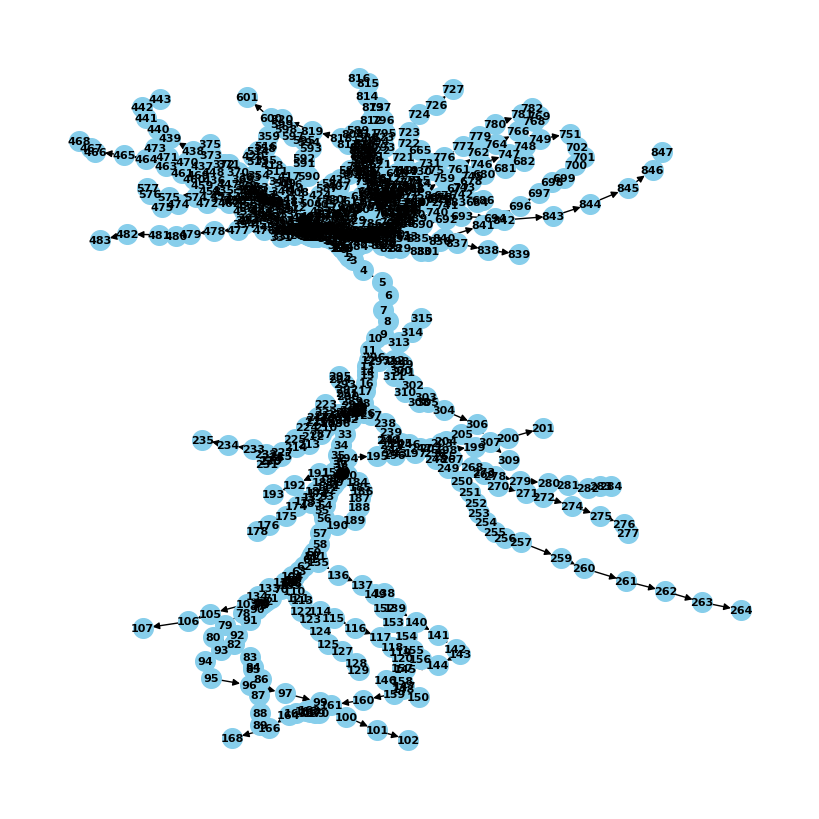

In [ ]:
pos = {i: (n["x"], n["y"]) for i, n in new_graph.nodes(data=True)}
plt.figure(figsize=(8, 8))
nx.draw(new_graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", font_family="sans-serif")
plt.show()

In [ ]:
# interpolate xyzr continously along the graph
# compute best split of the graph into compartments (groupwise?)

In [ ]:
# df = pd.DataFrame((net.trainable_params,net.indices_set_by_trainables, []), index=["param", "index", "value"])
# df = df.T.explode("index").explode("index").reset_index(drop=True)
# split_col = df["param"].apply(lambda d: next(iter(d.items())))
# df[["param", "value"]] = pd.DataFrame(split_col.tolist())
# df = df.astype({"index": int, "value": float, "param": str})
# trainable_iter = {i: {k:np.array([v]) for i,(k,v) in group[["param", "value"]].iterrows()} for i,group in  df.groupby("index")}

In [ ]:
# trainable_inds = np.unique(np.hstack(net.indices_set_by_trainables))
# trainable_params = {i:{} for i in trainable_inds}
# for i in trainable_inds:
#     for inds, params in zip(net.indices_set_by_trainables, net.trainable_params):
#         if i in inds.flatten():
#             trainable_params[i].update(params)
# trainable_iter = {k:{"trainables":v} for k,v in trainable_params.items()}
# module_graph.add_nodes_from(trainable_iter.items())

In [ ]:
# # since the original xyzr is not known, one cannot know where xyzr was measured
# # and where it was interpolated. Therefore, original.xyzr and from_graph.xyzr
# # will probably differ.
# if "x" in nodes.columns:
#     # interpolate xyzr between first and last only
#     first_branch_inds = nodes.reset_index().groupby("branch_index").first()["index"].values
#     last_branch_inds = nodes.reset_index().groupby("branch_index").last()["index"].values
#     first_xyzr = nodes.loc[first_branch_inds][["x", "y", "z", "radius"]]
#     last_xyzr = nodes.loc[last_branch_inds][["x", "y", "z", "radius"]]
#     dl = last_xyzr[["x", "y", "z"]].values - first_xyzr[["x", "y", "z"]].values
#     first_xyzr[["x", "y", "z"]] = first_xyzr[["x", "y", "z"]]-1/2*dl/(module.nseg-1)
#     last_xyzr[["x", "y", "z"]] = last_xyzr[["x", "y", "z"]]+1/2*dl/(module.nseg-1)
#     xyzr = [np.vstack([first, last]) for first, last in zip(first_xyzr.values, last_xyzr.values)]

### Ideas:
- add a `groups` property
- fix groups. currently view can be changed and hence outdated that is added to groups
- show group membership in nodes
- make use to to_graph in plotting
- make use of from graph in swc import
- modules can be saved as graph, no need for pickle necessarily
- prevent untrainable stuff, like `Na` from being made trainable!
- Do we really want to enforce nsegs equal? is it required?